In [ ]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Data Generator

In [21]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=640):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "images", id_name)
        mask_path = os.path.join(self.path, "masks", id_name)
        
        ## Reading Image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(image, (self.image_size, self.image_size))

        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if (index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        print("files_batch: ", files_batch)
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyperparameters

In [33]:
image_size = 640
train_path = "dataset/train/"
valid_path = "dataset/valid/"
epochs = 5
batch_size = 2

## Training Ids
train_ids = os.listdir(train_path + "/images")
valid_ids = os.listdir(valid_path + "/images")
print(train_ids)
print(valid_ids)


['58_jpg.rf.d5bfb4d3e05894b4a12e16d5fe6bf530.jpg', '59_jpg.rf.ebd6ba210bbd009d628b9121bbade046.jpg', '60_jpg.rf.3061fa8e836db60102706e41895278ea.jpg', 'a2_1_jpg.rf.25965515ffbb7977dcdf92708bb963d2.jpg']
['a31_1_jpg.rf.06195f74be1266371ceeb6875b8a9c70.jpg', 'a56_1_jpg.rf.0ecf2a8b76f2dd43a4a8b4ae6d0461f3.jpg']


In [23]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)
x, y = gen.__getitem__(1)
print(x.shape, y.shape)

files_batch:  ['58_jpg.rf.d5bfb4d3e05894b4a12e16d5fe6bf530.jpg', '59_jpg.rf.ebd6ba210bbd009d628b9121bbade046.jpg']
(2, 640, 640, 1) (2, 640, 640, 1)
files_batch:  ['60_jpg.rf.3061fa8e836db60102706e41895278ea.jpg', 'a2_1_jpg.rf.25965515ffbb7977dcdf92708bb963d2.jpg']
(2, 640, 640, 1) (2, 640, 640, 1)


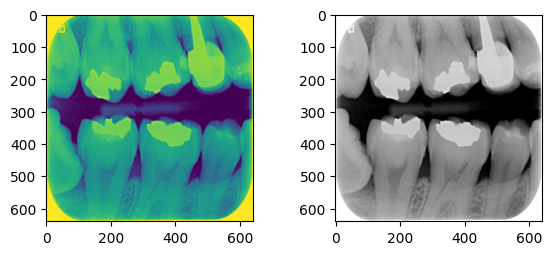

In [24]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

## Different Convolutional Blocks

In [25]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## UNet Model

In [35]:
def UNet():
    f = [80, 160, 320, 640, 1280]
    inputs = keras.layers.Input((image_size, image_size, 1))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #
    c2, p2 = down_block(p1, f[1]) #
    c3, p3 = down_block(p2, f[2]) #
    c4, p4 = down_block(p3, f[3]) #
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #
    u2 = up_block(u1, c3, f[2]) #
    u3 = up_block(u2, c2, f[1]) #
    u4 = up_block(u3, c1, f[0]) #
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [36]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 640, 640, 1)]        0         []                            
                                                                                                  
 conv2d_46 (Conv2D)          (None, 640, 640, 80)         800       ['input_4[0][0]']             
                                                                                                  
 conv2d_47 (Conv2D)          (None, 640, 640, 80)         57680     ['conv2d_46[0][0]']           
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 320, 320, 80)         0         ['conv2d_47[0][0]']           
 ng2D)                                                                                      

## Training the model

In [37]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

files_batch:  ['58_jpg.rf.d5bfb4d3e05894b4a12e16d5fe6bf530.jpg', '59_jpg.rf.ebd6ba210bbd009d628b9121bbade046.jpg']
Epoch 1/5


C:\Users\user\AppData\Local\Temp\ipykernel_2208\3804961854.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,


files_batch:  ['58_jpg.rf.d5bfb4d3e05894b4a12e16d5fe6bf530.jpg', '59_jpg.rf.ebd6ba210bbd009d628b9121bbade046.jpg']
files_batch:  ['60_jpg.rf.3061fa8e836db60102706e41895278ea.jpg', 'a2_1_jpg.rf.25965515ffbb7977dcdf92708bb963d2.jpg']


## Testing the model

In [ ]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")